In [39]:
import bagpy
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np
from tqdm import tqdm
import PIL.Image as Image 
import io
from matplotlib import pyplot as plt


In [40]:
from bagpy import bagreader

b = bagreader(r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\2021-03-12_11-41-55_0\2021-03-12_11-41-55_0.bag')



[INFO]  Data folder C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\2021-03-12_11-41-55_0\2021-03-12_11-41-55_0 already exists. Not creating.


In [41]:
bag = b.reader


topic_list = ['/em/fused_grid', '/sensorik/axis_front/image/compressed', '/vehicle/odometry', '/function/pathing_mlteleop']


pathing_msgs = []
grid_msgs = []
grid_seqs = []
odom_msgs = []
odom_seqs = []
image_msgs = []
image_seqs = []
count = 0
for topic, msg, t in bag.read_messages(topics=topic_list):
    if topic == "/function/pathing_mlteleop":
        pathing_msgs.append(msg)

    if topic == "/em/fused_grid":
        grid_msgs.append(msg)
        grid_seqs.append(msg.header.seq)
        
    if topic == "/vehicle/odometry":
        odom_msgs.append(msg)
        odom_seqs.append(msg.header.seq)
    if topic == "/sensorik/axis_front/image/compressed":
        image_msgs.append(msg)
        image_seqs.append(msg.header.seq)
    if count==10000:
        break
    else: count +=1
bag.close()

print('len')
print('pathing_msgs',len(pathing_msgs))
print('grid_msgs',len(grid_msgs))
print('odom_msgs',len(odom_msgs))
print('image_msgs',len(image_msgs))




len
pathing_msgs 227
grid_msgs 746
odom_msgs 5222
image_msgs 1315


In [66]:
list_odo_msgs = []
for i,examplary_pathing_msg in enumerate(tqdm(pathing_msgs)):
    odom_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.obstacle
    odom_idx = odom_seqs.index(odom_seq)
    odom_msg = odom_msgs[odom_idx]
    list_odo_msgs.append(odom_msg)
    #list_odo_msgs.append((odom_msg.pos_x,odom_msg.pos_y))
    #print("\n",odom_msg.pos_x,odom_msg.pos_y)
np_odo_data = np.asarray(list_odo_msgs)

100%|██████████| 227/227 [00:00<00:00, 6135.30it/s]


In [67]:
np_odo_data[0]

header: 
  seq: 152355
  stamp: 
    secs: 1615545723
    nsecs: 128974848
  frame_id: "odometry"
pos_x: 9.287986196577549
pos_y: -6.96800572425127
heading: 0.05906194188748811
slip_angle: 0.0
track_angle: 0.05906194188748811
sigma_pos_x: 8.348
sigma_pos_y: 10.064
sigma_heading: 0.13655456067603633
sigma_slip_angle: 0.0
sigma_track_angle: 0.0
status_flag: 0
counter_sync: 515899392

100%|██████████| 2/2 [00:00<00:00, 133.34it/s]


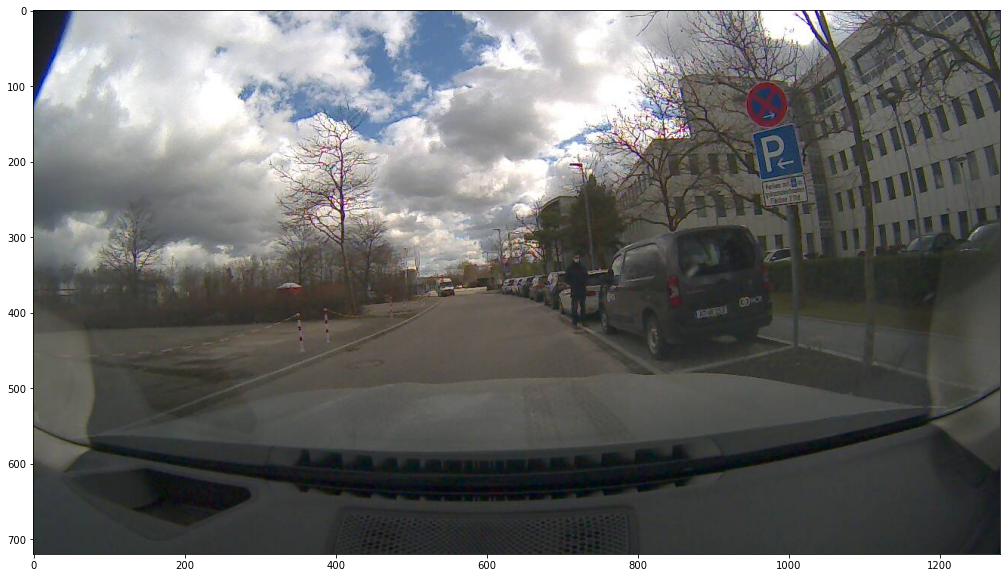

In [38]:
list_all_img_data=[]
for i,examplary_pathing_msg in enumerate(tqdm(pathing_msgs[0:2])):

    image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
    image_idx = image_seqs.index(image_seq)
    image_msg = image_msgs[image_idx]

    # Convert compressed image(byte string) to RAW using
    img = Image.open(io.BytesIO(image_msg.data))
    #convert PIL image object to numpy array
    np_img = np.asarray(img)
    list_all_img_data.append(np_img)

np_all_img_data = np.asarray(list_all_img_data)

plt.figure(figsize=(20,10))
plt.imshow(np_all_img_data[0])

In [68]:
_READ_ROSBAG =1
_MAX_LENGTH = 25
_ZERO_PADDING = 0

class np_maker():

    def __init__(self,pathing_msgs,max_length):
        self.pathing_msgs = pathing_msgs
        self.max_length = max_length
        self.extract_msg_cnt = 220

    @staticmethod
    def __np_reshape_frm_list(list_path,new_shape):
        return np.reshape((np.asarray(list_path)),new_shape)
    
    @staticmethod
    def __np_hstack_list(self,list1,list2,new_shape):
        assert len(list1)==len(list2)
        np_list1 = self.__np_reshape_frm_list(list1,new_shape)
        np_list2 = self.__np_reshape_frm_list(list2,new_shape)
        return np.hstack((np_list1,np_list2))
    
    @staticmethod
    def __padd_values(n,val):
        listofzeros = [val] * n
        return listofzeros
    
    @staticmethod
    def __padded_path(self,unpadded_path):
        padded_path = unpadded_path.extend(self.__padd_values(self.max_length-len(unpadded_path),0))
        return padded_path

    @staticmethod
    def __construct_path(list_of_points):
        path_x = [] 
        path_y = []
        for path in list_of_points:
            path_x.append(path.point.x)
            path_y.append(path.point.y)

        return path_x,path_y  

    @staticmethod
    def __assert_all_lengths(self,path1_x,path1_y,path2_x,path2_y):
        # check if every path is as long as the maximum length
        assert len(path1_x)==self.max_length 
        assert len(path1_y)==self.max_length 
        assert len(path2_x)==self.max_length 
        assert len(path2_y)==self.max_length

    def create_np_path(self):

        list_all_init_path = []
        list_all_opt_path = []
        print("Converting path data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            init_path_x,init_path_y = self.__construct_path(examplary_pathing_msg.path_options[0].reference_path)

            opt_path_x,opt_path_y = self.__construct_path(examplary_pathing_msg.path_options[2].reference_path)

            if _ZERO_PADDING:
                if len(init_path_x)<self.max_length:
                    init_path_x.extend(self.__padd_values(self.max_length-len(init_path_x),0))
                    #init_path_x = self.__padded_path(self,init_path_x)
                    init_path_y.extend(self.__padd_values(self.max_length-len(init_path_y),0))
            
                if len(opt_path_x)<self.max_length:
                    opt_path_x.extend(self.__padd_values(self.max_length-len(opt_path_x),0))
                    opt_path_y.extend(self.__padd_values(self.max_length-len(opt_path_y),0))
            else:

                if len(init_path_x)<self.max_length:
                    init_path_x.extend(self.__padd_values(self.max_length-len(init_path_x),init_path_x[-1]))
                    #init_path_x = self.__padded_path(self,init_path_x)
                    init_path_y.extend(self.__padd_values(self.max_length-len(init_path_y),init_path_y[-1]))
            
                if len(opt_path_x)<self.max_length:
                    opt_path_x.extend(self.__padd_values(self.max_length-len(opt_path_x),opt_path_x[-1]))
                    opt_path_y.extend(self.__padd_values(self.max_length-len(opt_path_y),opt_path_y[-1]))
            #check for length
            self.__assert_all_lengths(self,init_path_x,init_path_y,opt_path_x,opt_path_y)

            #pair x and y and 
            np_init_path = self.__np_hstack_list(self,init_path_x,init_path_y,new_shape=(self.max_length,1))
            np_opt_path = self.__np_hstack_list(self,opt_path_x,opt_path_y,new_shape=(self.max_length,1))
            
            # append paths from all pathing messages
            list_all_init_path.append(np_init_path)
            list_all_opt_path.append(np_opt_path)

        # Convert the all paths appended list to numpy array
        np_all_initp = np.asarray(list_all_init_path)
        np_all_optp = np.asarray(list_all_opt_path)        

        return np_all_initp,np_all_optp

    def create_np_grid(self):

        list_all_grid_data =[]
        print("Converting grid data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            #get sequences aligning with pathing messages
            grid_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.lane

            """
            grid is saved as vector in grid_msg.data
            grid_msg.info gives information about properties, i.e. width, height, resolution, position in odometry frame
            """
            grid_idx = grid_seqs.index(grid_seq)
            grid_msg = grid_msgs[grid_idx]

            grid_data = np.asarray(grid_msg.data)
            grid_data = grid_data.reshape(grid_msg.info.width, grid_msg.info.height)
            
            # append grid data
            list_all_grid_data.append(grid_data) 

        #converted appended grids to np array
        np_all_grid_data = np.asarray(list_all_grid_data)

        return np_all_grid_data

    def create_np_img(self):
        list_all_img_data =[]
        print("Converting grid data to numpy........ ")
        for i,examplary_pathing_msg in enumerate(tqdm(self.pathing_msgs)):

            image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
            image_idx = image_seqs.index(image_seq)
            image_msg = image_msgs[image_idx]

            # Convert compressed image(byte string) to RAW using
            img = Image.open(io.BytesIO(image_msg.data))
            #convert PIL image object to numpy array
            np_img = np.asarray(img)
            list_all_img_data.append(np_img)

        np_all_img_data = np.asarray(list_all_img_data)

        return np_all_img_data



In [71]:
convert_2_np = np_maker(pathing_msgs,25)
np_init_path,np_opt_path = convert_2_np.create_np_path()
#np_grid_data = convert_2_np.create_np_grid()
#np_img_data = convert_2_np.create_np_img()

print((np_init_path[0]))
#print(np.shape(np_img_data))

100%|██████████| 227/227 [00:00<00:00, 11947.63it/s]Converting path data to numpy........ 
[[13.97997853 -6.57004453]
 [15.92898345 -6.37848388]
 [17.87734589 -6.18036233]
 [19.82479265 -5.973425  ]
 [21.77184418 -5.7628317 ]
 [23.71850047 -5.54858243]
 [25.66438606 -5.32744245]
 [27.60984283 -5.10259317]
 [29.55487076 -4.87403457]
 [31.49891977 -4.63730003]
 [33.44227877 -4.39503705]
 [35.38494776 -4.14724566]
 [37.32527467 -3.88180571]
 [39.26166551 -3.5909147 ]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]
 [41.19412026 -3.27457262]]



In [36]:
#save non zero padding (padding with last value) with _nzp extention in file name

#np.save('_np_imgdata',np_img_data)
#np.save('_np_initpath_nzp',np_init_path)
#np.save('_np_optpath_nzp',np_opt_path)
#np.save('_np_griddata',np_grid_data)

In [22]:
np_grid_data = np.load('_np_griddata.npy',allow_pickle=True)

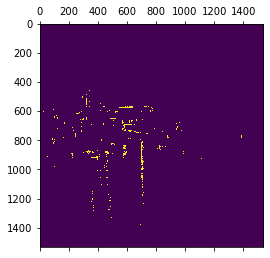

In [27]:
from matplotlib import pyplot as plt 
plt.matshow(np_grid_data[0])

In [13]:
# Example for a single pathing_msg:
init_path_x = []
init_path_y = []
opt_path_x = []
opt_path_y = []

grid_msg = None
image_msg = None
odom_msg = None

max_length = 25
np_init_paths = np.empty((1,max_length,2))

for examplary_pathing_msg in pathing_msgs[0:1]:
    #examplary_pathing_msg = pathing_msgs[0]
    
    print("examplary_pathing_msg")
    #print(examplary_pathing_msg)

    '''
    for init_path in examplary_pathing_msg.path_options[0].reference_path:
        init_path_x.append(init_path.point.x)
        init_path_y.append(init_path.point.y)
    '''
    init_path_x, init_path_y = construct_path(examplary_pathing_msg.path_options[0].reference_path)
    init_path_x = padd_w_value(init_path_x,0,25)
    opt_path_x, opt_path_y = construct_path(examplary_pathing_msg.path_options[2].reference_path)

    '''
    for opt_path in examplary_pathing_msg.path_options[2].reference_path:
        opt_path_x.append(opt_path.point.x)
        opt_path_y.append(opt_path.point.y)
    '''
    # corresponding occupancy grid, camera and odometry sequences (ID's):
    # this saving method is a workaround for the corresponding ID's
    grid_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.lane
    image_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.road
    odom_seq = examplary_pathing_msg.path_options[1].reference_path[0].left_boundaries.obstacle

    # corresponding occupancy grid, camera and odometry messages:
    """
    grid is saved as vector in grid_msg.data
    grid_msg.info gives information about properties, i.e. width, height, resolution, position in odometry frame
    """
    grid_idx = grid_seqs.index(grid_seq)
    grid_msg = grid_msgs[grid_idx]
    # print('grid_msg.info')
    # print(grid_msg.info)

    """
    1280x720, RGB Image
    """
    image_idx = image_seqs.index(image_seq)
    image_msg = image_msgs[image_idx]
    # Convert compressed image to RAW
    #bridge = CvBridge()
    #img = bridge.compressed_imgmsg_to_cv2(image_msg)
    # print(img.shape)

    """
    odom_msg provides information about the current position in the odometry frame (pos_x, pos_y, heading)
    the idea is to provide the NN information for the correlation between camera image, the corresponding car position and the path to be optimized/predicted
    """
    odom_idx = odom_seqs.index(odom_seq)
    odom_msg = odom_msgs[odom_idx]

examplary_pathing_msg
